In [ ]:
!unzip command_dataset.zip

Archive:  command_dataset.zip
  inflating: command_dataset/yes/yes_99.wav  
  inflating: command_dataset/yes/yes_53.wav  
  inflating: command_dataset/yes/yes_44.wav  
  inflating: command_dataset/yes/yes_90.wav  
  inflating: command_dataset/yes/yes_47.wav  
  inflating: command_dataset/yes/yes_56.wav  
  inflating: command_dataset/yes/yes_92.wav  
  inflating: command_dataset/yes/yes_80.wav  
  inflating: command_dataset/yes/yes_77.wav  
  inflating: command_dataset/yes/yes_94.wav  
  inflating: command_dataset/yes/yes_52.wav  
  inflating: command_dataset/yes/yes_97.wav  
  inflating: command_dataset/yes/yes_57.wav  
  inflating: command_dataset/yes/yes_62.wav  
  inflating: command_dataset/yes/yes_82.wav  
  inflating: command_dataset/yes/yes_45.wav  
  inflating: command_dataset/yes/yes_95.wav  
  inflating: command_dataset/yes/yes_46.wav  
  inflating: command_dataset/yes/yes_76.wav  
  inflating: command_dataset/yes/yes_66.wav  
  inflating: command_dataset/yes/yes_87.wav  
  in

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import IPython.display as ipd

# Define your commands
COMMANDS = ['yes', 'no', 'play', 'stop']

# Set path to your custom dataset
custom_dataset_path = '/content/command_dataset'

In [ ]:
# Create data arrays
X = []  # Will hold audio features
y = []  # Will hold labels

# Process audio files
for command in COMMANDS:
    print(f"Processing {command} files...")
    command_dir = os.path.join(custom_dataset_path, command)

    for filename in os.listdir(command_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(command_dir, filename)
            try:
                # Load audio file
                audio, sr = librosa.load(file_path, sr=16000, duration=1)

                # Ensure consistent length
                if len(audio) < sr:
                    audio = np.pad(audio, (0, sr - len(audio)))
                else:
                    audio = audio[:sr]

                # Extract MFCC features with more coefficients
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)

                # Add delta features (changes over time)
                delta_mfccs = librosa.feature.delta(mfccs)
                delta2_mfccs = librosa.feature.delta(mfccs, order=2)

                # Combine features
                combined_features = np.concatenate([mfccs, delta_mfccs, delta2_mfccs], axis=0)

                # Add to dataset
                X.append(combined_features)
                y.append(command)
            except Exception as e:
                print(f"Error processing {file_path}: {str(e)}")

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Print initial shape
print(f"X shape: {X.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

Processing yes files...
Processing no files...
Processing play files...
Processing stop files...
X shape: (450, 60, 32)


In [ ]:
# Build CNN+LSTM model
def create_cnn_lstm_model(input_shape, num_classes):
    """
    Create a model that combines CNN and LSTM layers for audio classification.
    CNN layers extract features, then LSTM processes the temporal relationships.
    """
    model = models.Sequential([
        # CNN layers to extract features
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        # Reshape for LSTM: (batch, time_steps, features)
        # Convert the 2D feature maps to a sequence
        layers.Reshape((-1, 128)),

        # LSTM layers to process temporal patterns
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.4),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dropout(0.4),

        # Dense layers for classification
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Reshape X for CNN input (samples, height, width, channels)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Create the model
model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2], 1), len(COMMANDS))

# Print model summary
model.summary()

# Compile model with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Fixed learning rate

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 60, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 60, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 30, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 8, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 15, 8, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 15, 8, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 120, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 120, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 308,740 (1.18 MB)

 Trainable params: 308,036 (1.18 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# Train with callbacks (keep the rest of the callbacks)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.0001
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_cnn_lstm_model.h5',
            save_best_only=True,
            monitor='val_accuracy'
        )
    ]
)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.3423 - loss: 1.7471

18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 353ms/step - accuracy: 0.3444 - loss: 1.7408 - val_accuracy: 0.4444 - val_loss: 1.2885 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - accuracy: 0.5480 - loss: 1.2133 - val_accuracy: 0.4444 - val_loss: 1.2763 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7031 - loss: 0.8284

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 314ms/step - accuracy: 0.7034 - loss: 0.8259 - val_accuracy: 0.7222 - val_loss: 1.0517 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step - accuracy: 0.8105 - loss: 0.5436 - val_accuracy: 0.5833 - val_loss: 0.9502 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8577 - loss: 0.4170 - val_accuracy: 0.4583 - val_loss: 1.1383 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8928 - loss: 0.3094

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.8919 - loss: 0.3096 - val_accuracy: 0.8472 - val_loss: 0.5039 - learning_rate: 0.0010
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step - accuracy: 0.8922 - loss: 0.2788 - val_accuracy: 0.7222 - val_loss: 0.7353 - learning_rate: 0.0010
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9277 - loss: 0.1669

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.9280 - loss: 0.1675 - val_accuracy: 0.9028 - val_loss: 0.3462 - learning_rate: 0.0010
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - accuracy: 0.9287 - loss: 0.1803 - val_accuracy: 0.8889 - val_loss: 0.3216 - learning_rate: 0.0010
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.9678 - loss: 0.1327 - val_accuracy: 0.8472 - val_loss: 0.5595 - learning_rate: 0.0010
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.9569 - loss: 0.1148 - val_accuracy: 0.8056 - val_loss: 0.3931 - learning_rate: 0.0010
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - accuracy: 0.9923 - loss: 0.0517 - val_accuracy: 0.8194 - val_loss: 0.4637 - learning_rate: 0.0010
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9913 - loss: 0.0234

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step - accuracy: 0.9916 - loss: 0.0230 - val_accuracy: 0.9861 - val_loss: 0.0524 - learning_rate: 0.0010
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.9933 - loss: 0.0218 - val_accuracy: 0.9861 - val_loss: 0.0499 - learning_rate: 0.0010
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 361ms/step - accuracy: 0.9949 - loss: 0.0377 - val_accuracy: 0.7917 - val_loss: 1.0157 - learning_rate: 0.0010
Epoch 16/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.9343 - loss: 0.1752 - val_accuracy: 0.9583 - val_loss: 0.1257 - learning_rate: 0.0010
Epoch 17/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.9405 - loss: 0.1356 - val_accuracy: 0.8611 - val_loss: 0.3843 - learning_rate: 0.0010
Epoch 18/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step - accuracy: 0.9704 - loss: 0.1048 - val_accuracy: 0.8611 - val_loss: 0.5617 - learning_rate: 0.0010
Epoch 19/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.9851 - loss: 0.0561 - v

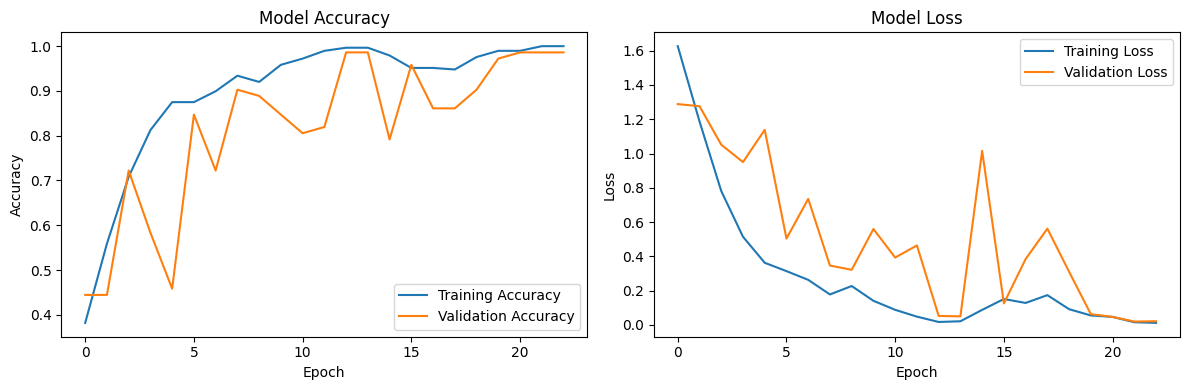

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Function to predict with the CNN+LSTM model
def predict_command_cnn_lstm(audio_file, model, label_encoder):
    """
    Predict the command from an audio file using the CNN+LSTM model.
    """
    try:
        # Load audio
        audio, sr = librosa.load(audio_file, sr=16000, duration=1)

        # Print audio info for debugging
        print(f"Audio length: {len(audio)}, Sample rate: {sr}")
        print(f"Audio min: {audio.min():.4f}, max: {audio.max():.4f}, mean: {audio.mean():.4f}")

        # Preprocess
        if len(audio) < sr:
            audio = np.pad(audio, (0, sr - len(audio)))
        else:
            audio = audio[:sr]

        # Extract same features as training
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        combined_features = np.concatenate([mfccs, delta_mfccs, delta2_mfccs], axis=0)

        # Reshape for CNN input
        features = combined_features.reshape(1, combined_features.shape[0], combined_features.shape[1], 1)

        # Get prediction
        predictions = model.predict(features, verbose=0)

        # Get the predicted class index
        predicted_index = np.argmax(predictions[0])

        # Get the confidence score
        confidence = float(predictions[0][predicted_index])

        # Get the command name
        commands = label_encoder.classes_
        predicted_command = commands[predicted_index]

        # Print all confidences
        print("\nConfidence scores:")
        for i, command in enumerate(commands):
            print(f"{command}: {predictions[0][i]*100:.2f}%")

        return predicted_command, confidence

    except Exception as e:
        print(f"Error predicting command: {e}")
        return None, 0.0

# Save model
model.save('cnn_lstm_command_model.h5')
print("Model saved as 'cnn_lstm_command_model.h5'")

Model saved as 'cnn_lstm_command_model.h5'


In [ ]:
command, confidence = predict_command_cnn_lstm("/content/test_no.wav", model, label_encoder)
print(f"Predicted command: {command} with {confidence*100:.2f}% confidence")

Audio length: 16000, Sample rate: 16000
Audio min: -0.1487, max: 0.1076, mean: -0.0000

Confidence scores:
no: 96.75%
play: 1.29%
stop: 1.01%
yes: 0.94%
Predicted command: no with 96.75% confidence


In [ ]:
command, confidence = predict_command_cnn_lstm("/content/test_yes.wav", model, label_encoder)
print(f"Predicted command: {command} with {confidence*100:.2f}% confidence")

Audio length: 16000, Sample rate: 16000
Audio min: -0.1821, max: 0.2030, mean: 0.0001

Confidence scores:
no: 0.30%
play: 0.27%
stop: 0.60%
yes: 98.82%
Predicted command: yes with 98.82% confidence


In [ ]:
command, confidence = predict_command_cnn_lstm("/content/test_play.wav", model, label_encoder)
print(f"Predicted command: {command} with {confidence*100:.2f}% confidence")

Audio length: 12938, Sample rate: 16000
Audio min: -0.1895, max: 0.2510, mean: -0.0002

Confidence scores:
no: 4.14%
play: 85.68%
stop: 1.34%
yes: 8.84%
Predicted command: play with 85.68% confidence


In [ ]:
command, confidence = predict_command_cnn_lstm("/content/test_stop.wav", model, label_encoder)
print(f"Predicted command: {command} with {confidence*100:.2f}% confidence")

Audio length: 16000, Sample rate: 16000
Audio min: -0.1702, max: 0.2837, mean: 0.0001

Confidence scores:
no: 8.37%
play: 2.37%
stop: 81.76%
yes: 7.49%
Predicted command: stop with 81.76% confidence


In [ ]:
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']